In the following code, the use of evolutionary algorithms is explored for solving computationally hard problems.
Specifically, the travelling salesman problem is used as a test case. In short, the problem is as follows:
given a set of cities, what is the shortest path the salesman can take so that all cities are visited once?

First, random city locations are generated to set up the problem. Following that, a simple exponential time algorithm
is provided as baseline for smaller test cases (my computer crashed at n = 30...). Finally, the evolutionary algorithm
is provided and explored. 

https://en.wikipedia.org/wiki/Travelling_salesman_problem

In [1]:
import numpy as np
import math
import time
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from itertools import combinations

First we want to create a dataset to use. For this I randomly generate "cities" on a 1000x1000 grid. 

In [2]:
def generate_cities(n):
    # generating fake city locations
    coordinates = np.random.uniform(0, 1000, [n, 2])

    # calculate Euclidean distance between all the cities and saving to a matrix
    # this allows us to simply reference the matrix when scoring paths
    distance_matrix = np.zeros([n, n])
    for i in range(n):
        for j in range(i):
            # matrix is symmetric, so there is some redudancy, but this makes it simpler to work with and the extra memory isn't an issue
            distance_matrix[i, j] = np.linalg.norm(coordinates[i] - coordinates[j])
            distance_matrix[j, i] = np.linalg.norm(coordinates[i] - coordinates[j])

    return(distance_matrix, coordinates)

In [3]:
# n is the number of cities and is used for most functions below
n = 20
distance_matrix, coordinates = generate_cities(n)

Below is a simple search algorithm that we can use as a benchmark for speed and accuracy. It uses some dynamic programming ideas to bring it down from factorial time to exponential time (though requiring some more memory).  

In [4]:
def dynamic_search_algorithm(n, distance_matrix): 
    saved_results = dict()
    def C(S, i):
        if (S, i) in saved_results:
            return(saved_results[S, i])
        if len(S) == 1:
            result = distance_matrix[0, i]
        else:
            result = 2**64
            for q in S:
                S_without_q = tuple([x for x in S if x != q])
                test = C(S_without_q, q) + distance_matrix[q, i]
                if test < result:
                    result = test
        saved_results[S,i] = result
        return(saved_results[S, i])

    for k in range(1,n):
        for S in combinations(range(1,n), k):
            for j in range(1,n):
                if j not in S:
                    C(S, j)
            if k == n-1:
                best_path_distance = C(S,j) + distance_matrix[j,0]
    return(best_path_distance)

In [5]:
t0 = time.time()
min_cost_path = dynamic_search_algorithm(n, distance_matrix)
t1 = time.time()
runtime = t1 - t0
print('Solution cost: ' + str(min_cost_path))
print('Runtime: ' + str(runtime))

Solution cost: 1862.0556311151313
Runtime: 0.0009970664978027344



Evolutionary algorithm implemention time! In order to construct an evolutionary algorithm, we need 3 basic things:
1. A way to encode candidate solutions.
2. A way to judge the solutions. (Selection)
3. A way to construct new candidates using the successful ones. (Reproduction)
4. Optional: A way for the algorithm to explore by randomly changing candidates. (Mutation)

We can encode each solution pretty easily; each one can simply be a permutation of the cities. We can judge the solutions based on the distance travelled based the order of the cities in a given permutation and choose the top half of solutions. There are many different ways to construct new candidates. For this implementation, we will randomly choose a segment of one parent, and then fill in the remaining spots using the other parent. An example is shown below. For mutation, a random proportion of candidates are chosen 2 cities are swapped. 

Example: given the two parents below, the chosen segement is the middle 3 positions.

Parents:

[1, 2, 4, 5, 6, 3, 7] (Start at city 1, go to 2, then 4, 5, 6, 3, 7 and back to 1)

[4, 5, 2, 3, 1, 6, 7]

Offspring:

[4, 5, 2, 3, 1, 6, 7]

[2, 3, 4, 5, 6, 1, 7]

In [6]:
# Some functions to initialize and perform selection

# Initialize an array of possible candidates
def create_candidates(n, num_candidates):
    candidates = np.zeros([num_candidates, n])
    for i in range(num_candidates):
        candidates[i] = np.random.permutation(n)
    return(candidates)

# Return total path distance of a candidate solution. Lower the better!
def distance(candidate, distance_matrix, n):
    distance = 0
    for i in range(n):
        distance += distance_matrix[int(candidate[i-1]), int(candidate[i])]
    return(distance)    

# Select the best half of candidates based on lowest total path distances, discarding the rest.  
def selection(candidates, distance_matrix, n, return_distances = False):
    # calculate distances (score) for each candidate
    distances = np.zeros(len(candidates))
    for i in range(len(candidates)):
        distances[i] = distance(candidates[i], distance_matrix, n)
    # take the top half of candidates and return them as "survivors"
    number_survivors = len(candidates)//2 
    survivor_indices = (distances).argsort()[:number_survivors]
    survivors = []
    for i in survivor_indices:
        survivors.append(candidates[i])
    if return_distances:
        return(survivors, distances[(distances).argsort()[:number_survivors]])
    return(survivors)

In [7]:
# Functions to perform crossover step

# This function performs crossover as outlined above. It selects a random segment of each candidate
# to pass on to the children, and then fills in the remaining spots. 
def crossover(candidate_A, candidate_B, n):
    segment_points = np.random.randint(1, n, 2)
    start = min(segment_points)
    stop = max(segment_points)
    child_A = np.full(n, n + 1)
    child_B = np.full(n, n + 1)
    child_A[start:stop] = candidate_A[start:stop]
    child_B[start:stop] = candidate_B[start:stop]
    
    j = 0
    k = 0
    for i in range(n):
        if child_A[i] == n + 1:
            while candidate_B[j] in child_A:
                j += 1
            child_A[i] = candidate_B[j]
        if child_B[i] == n + 1:
            while candidate_A[k] in child_B:
                k += 1
            child_B[i] = candidate_A[k]
    return(child_A, child_B)

# Using the selected survivors, return a new array with those survivors and their children
def create_children(survivors, n):
    np.random.shuffle(survivors)
    new_survivors = np.zeros([len(survivors), n])
    for i in range(len(survivors)//2):
        new_survivors[2 * i], new_survivors[2 * i + 1] = crossover(survivors[i], survivors[i + 1], n)
    return(np.vstack((survivors, new_survivors)))

In [8]:
# Before repeating the selection and crossover processes, some portion of the candidates
# are randomly mutated. This helps the algorithm "explore" new possibilities. 
def mutate(candidate, n):
    point_a, point_b = np.random.randint(1, n, 2)
    new_candidate = candidate.copy()
    new_candidate[point_a] = candidate[point_b]
    new_candidate[point_b] = candidate[point_a]
    return(new_candidate)

def random_mutations(candidates, prob, n):
    random_numbers = np.random.uniform(size = len(candidates))
    new_candidates = candidates
    for i in range(len(random_numbers)):
        if random_numbers[i] < prob:
            new_candidates[i] = mutate(candidates[i], n)
    return(new_candidates)

In [9]:
def evolutionary_algorithm(n, distance_matrix, num_candidates = 100, iterations = 100, return_distances = True, prob = .02):
    # initialize
    candidates = create_candidates(n, num_candidates)
    # create vector to save the min distances. This will let us see how the results improve over time
    min_distances = []
    for i in range(iterations):
        # selection
        if return_distances:
            survivors, distances = selection(candidates, distance_matrix, n, return_distances)
            # keep track of minimum path distance
            min_distances.append(min(distances))
        else:
            survivors = selection(candidates, distance_matrix, n, return_distances)
        # crossover
        new_candidates = create_children(survivors, n)
        # mutation
        candidates = random_mutations(new_candidates, prob, n)
    # choose the most fit candidate
    best_distance = 2**64
    for i in range(len(candidates)):
        curr_distance = distance(candidates[i], distance_matrix, n)
        if curr_distance < best_distance:
            best_distance = curr_distance
            best_ind = i
    return(candidates[best_ind], min_distances)

In [10]:
t0 = time.time()
best_candidate, min_distances = evolutionary_algorithm(n, distance_matrix, iterations = 200)
t1 = time.time()
evolution_runtime = t1-t0
print(min(min_distances))
print(evolution_runtime)

2127.870992997343
0.7350356578826904


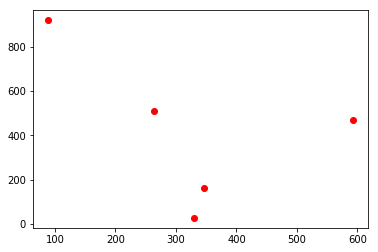

In [11]:
# Showing the generated cities
plt.plot(coordinates[:,0],coordinates[:,1], 'ro')
plt.savefig('evoltravellingsalesman' + str(n) + '.png')
plt.show()

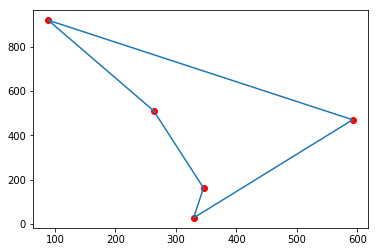

In [12]:
# visualizing the solution
x_coordinates = coordinates[best_candidate.astype(int)[-1:n], 0]
plt.plot(coordinates[:,0],coordinates[:,1], 'ro')
plt.plot(coordinates[np.append(best_candidate, best_candidate[0]).astype(int), 0], 
         coordinates[np.append(best_candidate, best_candidate[0]).astype(int), 1])
plt.savefig('evoltravellingsalesmanbestsol' + str(n) + '.png')
plt.show()

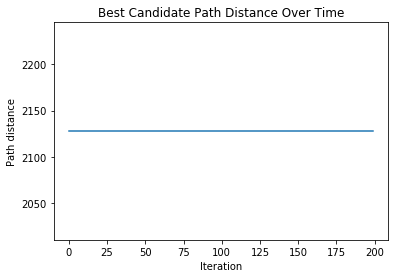

In [13]:
# training iterations
iterations = 200
x = np.arange(iterations)
plt.title('Best Candidate Path Distance Over Time')
plt.xlabel('Iteration')
plt.ylabel('Path distance')
plt.savefig('evoltravellingsalesmantraining' + str(n) + '.png')
plt.plot(x, min_distances)